# Supervised Machine Learning Project: Predicting Heart Disease

# Summary

Cardiovascular diseases (CVDs) or heart diseases are the most prevalent disease globally. According to the World Health Organization (WHO), heart disease is the primary cause of death around the world and is estimated to cause about 17.9 million deaths a year, with four out of five deaths due to heart attacks and strokes

This is notebook was created investigate heart disease using a heart disease dataset from UC Irvine Machine Learning Repository. I will be using the processed Cleveland dataset since it has already been recduced from the original 76 attributes to 14. The goal is to predict if a patient has heart disease or not based on 13 features by creating multiple supervised machine learning models. Before this is done the data will be cleaned to find any missing values and potentially scaled or transformed to improved the ML model.

# Objective

Given the prevalence of heart disease and its impact on global health, this report intends to examine data collected as part of the Cleveland dataset and explored the following:

* What are the distributions of the variables such as sex, age, blood pressure, etc. - also explore how meaningful these factors are by applying and interpreting the results of statistical tests.  
* Is there a difference in presence of heart disease in men and women? The null hypothesis is that there is no difference between sexes.  
* What are the relationships between the variables and the prevalence of heart disease? Through our analysis, we intend to discuss these variables and draw conclusions on their impact on the presence of heart disease.  

Finally to develop various machine learning models to predict what patient has heart disease, and then compare different models to one another while checking individual models scoring metrics to comfirm the quality of the model created.

# Import all Python Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy import stats

from matplotlib import rcParams
rcParams['figure.figsize'] = 10,8
sns.set_theme()

## Read csv file into Pandas Dataframe

In [2]:
columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']
df = pd.read_csv('data.csv', names=columns)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# Data Preperation

A key rationale for the choice of the dataset (Cleveland rather than the other three) was the cleanliness of the original dataset as it would better lend to initial exploratory analysis and the development of a potential model.
The data preparation process was as follows:

* Acquire data: Reading data from the aforementioned sources;

* Set up the environment: In Pandas, libraries were imported with a comprehensive setup to run data frames and visualisation as well as statistics analysis;

* Prepare data for analysis:  
    -Imported the data  
    -Identified variables  
    -Cleaned undesired columns, checked for nulls  
    -Changed datatypes to numeric  
    
    
* Develop more variables for analysis: Created new data frame or changed existed ones as necessary for more in-depth analysis if needed:  
-Mapped multiple categories of disease to a old feature, 'num', which is either healthy (0) or has signs of heart disease (1). Previously this has a value from zero to four, though we are changing the problem to a binary classification problem   


* Perform analysis: Performed quantitative data analysis (Discrete) or Exploratory Data Analysis (EDA) for the data that covers heart disease.

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


---

Columns 'ca' and 'thal' have dtype object but appear to be numerical values from the third cell above.

We notice below that there are rows with values filled in with '?', specifically 'ca' and 'thal' columns.

In [5]:
df[df['thal'] == '?']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2


In [6]:
df[df['ca'] == '?']

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


We have two rows with unknown 'thal' values and four rows with unknown 'ca' values. These rows will be dropped for a cleaner dataset.

In [3]:
drop_rows = [*df[df['thal'] == '?'].index.values, *df[df['ca'] == '?'].index.values]
df.drop(drop_rows, axis=0, inplace=True)

We also change the dtype of columns 'thal' and 'ca' to 'float64'.

In [4]:
df[['thal','ca']] = df[['thal','ca']].astype('float64')

Since we are only trying to predict if a patient has heart disease we will change the values in the 'num' column to a binary value of 0 or 1. Since this column represents the diagnosis of heart disease (angiographic disease status) where a value 0: < 50% diameter narrowing and a value greater than 1: > 50% diameter narrowing then any number great than zero will be changed to a one.

We also create a copy of the Dataframe below so we can test to see if our transformations improve our models prediction ability.

In [5]:
df.loc[(df.num > 0),'num']=1
df_T = df.copy()

# Exploratory Data Analysis

The 14 attributes in this dataset are:
1. age - numerical 
2. sex - cateforical 0-female, 1-male
3. cp - chest pain, categorical 1-typical angina, 2-atypical angina, 3-non-anginal pain, 4-asymptomatic 
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital), numerical
5. chol - serum cholestorel in mg/dl, numerical 
6. fbs - fasting blood sugar > 120 mg/dl, binary 0-false, 1-true 
7. restecg - resting electrocardiographic results, categorical 0-normal, 1-having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2-showing probable or definite left ventricular hypertrophy by Estes' criteria 
8. thalach - maximum heart rate achieved, numerical
9. exang - exercise induced angina, binary 0-false, 1-true
10. oldpeak - ST depression induced by exercise relative to rest, numerical
11. slope - the slope of the peak exercise ST segment, categorical 0-upsloping, 1-flat, 2-downsloping
12. ca - number of major vessels (0-3) colored by flourosopy, categorical 
13. thal - categorical  3-normal, 6-fixed defect, 7-reversable defect 
14. num - target variable, originally had value 0-4 but now only 0 or 1 as explained in section above.


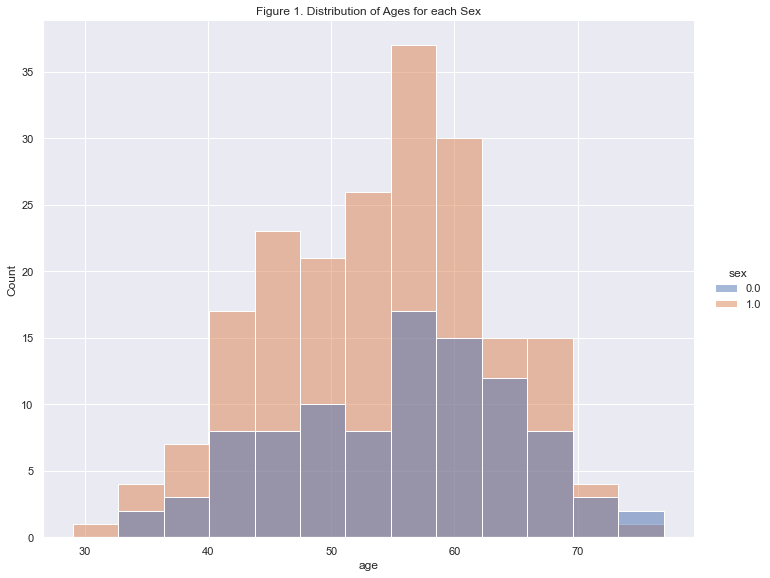

In [6]:
sns.displot(df, x="age", hue='sex', height=8, aspect=10/8)
plt.title('Figure 1. Distribution of Ages for each Sex');

In [66]:
num_m = len(df[df['sex'] == 1.0]) # number of males
num_f = len(df[df['sex'] == 0.0]) # number of females
print('Number of males in study are {} out of {}'.format(num_m,len(df)))
print('Number of females in study are {} out of {}'.format(num_f,len(df)))

Number of males in study are 201 out of 297
Number of females in study are 96 out of 297


We can see most of the patients in this dataset are males. It is also a small dataset with only 297 patients, which is too small by modern 'big data' standards.

In figure 2 we note there is a much higher chance of males having heart disease at 55.72%, and lower for females at 26.04%.

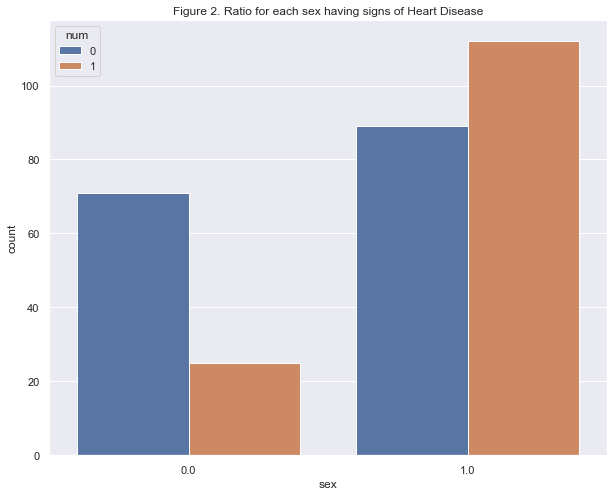

In [78]:
sns.countplot(x='sex', hue="num", data=df)
plt.title('Figure 2. Ratio for each sex having signs of Heart Disease');

In [67]:
num_md = len(df[(df['num'] > 0) & (df['sex'] == 1.0)]) # males with heart disease
num_fd = len(df[(df['num'] > 0) & (df['sex'] == 0.0)]) # females with heart disease
print('Percentage of males in study with heart disease is {}%'.format(round(num_md/num_m*100,2)))
print('Percentage of females in study with heart disease is {}%'.format(round(num_fd/num_f*100,2)))

Percentage of males in study with heart disease is 55.72%
Percentage of females in study with heart disease is 26.04%


In [409]:
df.corr()[['num']].sort_values(by='num',ascending=False)

,num
num,1.000000
thal,0.526640
ca,0.463189
oldpeak,0.424052
exang,0.421355
cp,0.408945
slope,0.333049
sex,0.278467
age,0.227075
restecg,0.166343


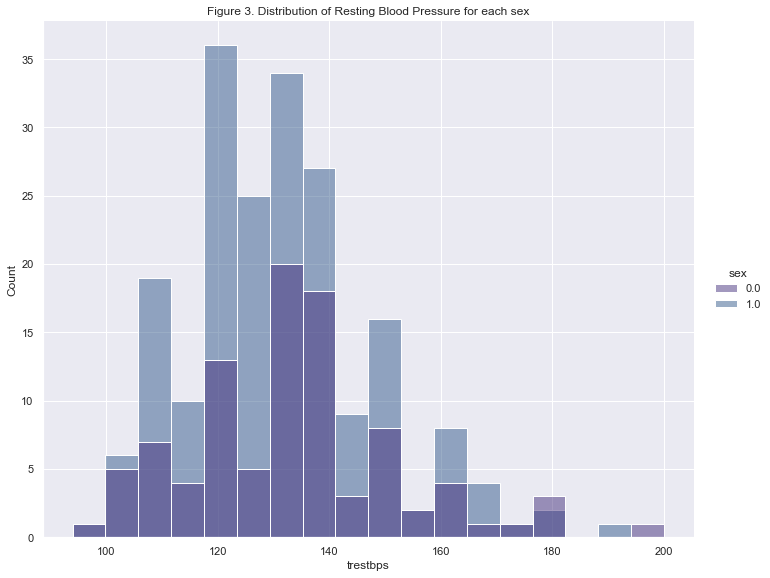

In [20]:
sns.set_palette("viridis")
sns.displot(x="trestbps", hue='sex', data=df, height=8, aspect=10/8)
plt.title('Figure 3. Distribution of Resting Blood Pressure for each sex');

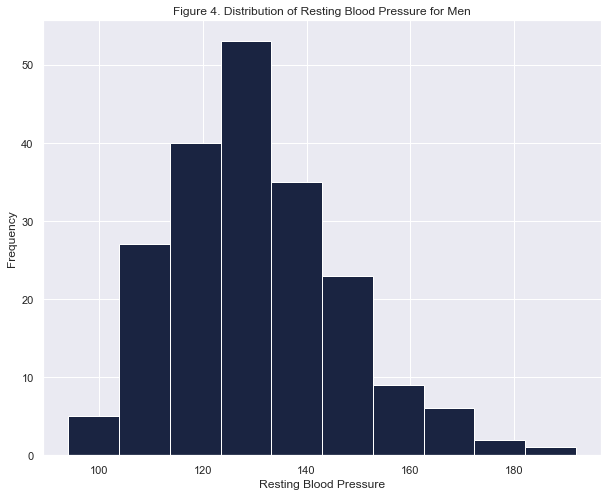

In [21]:
sns.set_palette("cubehelix")
df[(df['trestbps'] > 0) & (df['sex'] == 1.0)].trestbps.plot(kind='hist')
plt.title('Figure 4. Distribution of Resting Blood Pressure for Men')
plt.xlabel('Resting Blood Pressure');

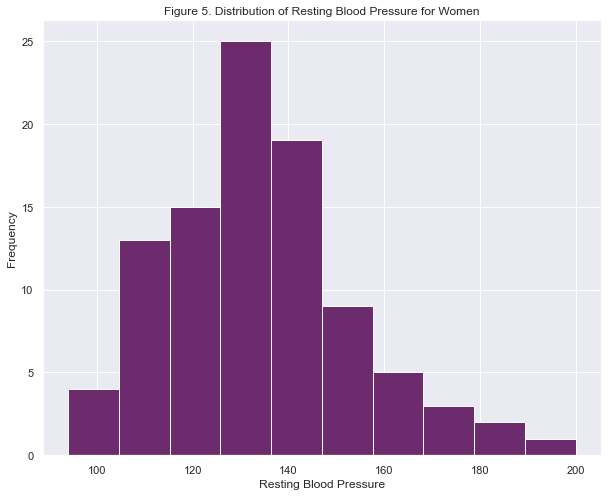

In [30]:
sns.set_palette("flare_r")
df[(df['trestbps'] > 0) & (df['sex'] == 0.0)].trestbps.plot(kind='hist')
plt.title('Figure 5. Distribution of Resting Blood Pressure for Women')
plt.xlabel('Resting Blood Pressure');

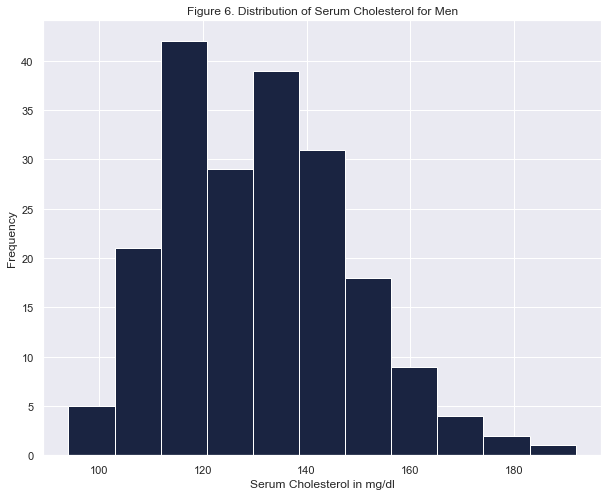

In [22]:
sns.set_palette("cubehelix")
df[(df['chol'] > 0) & (df['sex'] == 1.0)].trestbps.plot(kind='hist', bins=11)
plt.title('Figure 6. Distribution of Serum Cholesterol for Men')
plt.xlabel('Serum Cholesterol in mg/dl');

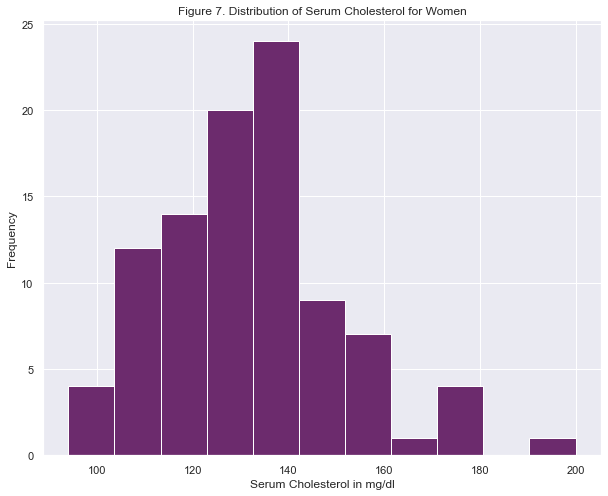

In [29]:
sns.set_palette("flare_r")
df[(df['chol'] > 0) & (df['sex'] == 0.0)].trestbps.plot(kind='hist', bins=11)
plt.title('Figure 7. Distribution of Serum Cholesterol for Women')
plt.xlabel('Serum Cholesterol in mg/dl');

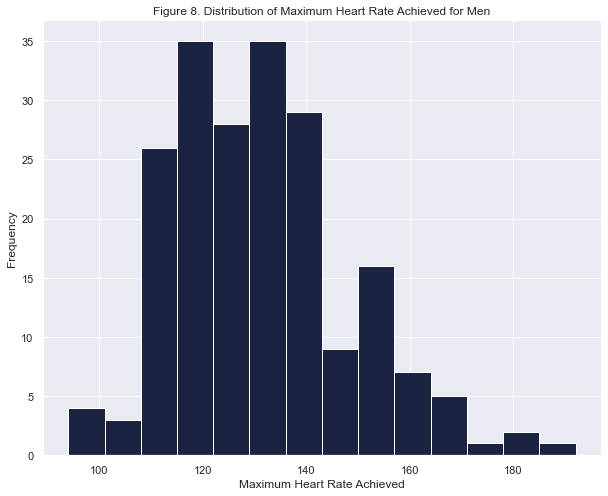

In [23]:
sns.set_palette("cubehelix")
df[(df['thalach'] > 0) & (df['sex'] == 1.0)].trestbps.plot(kind='hist', bins=14)
plt.title('Figure 8. Distribution of Maximum Heart Rate Achieved for Men')
plt.xlabel('Maximum Heart Rate Achieved');

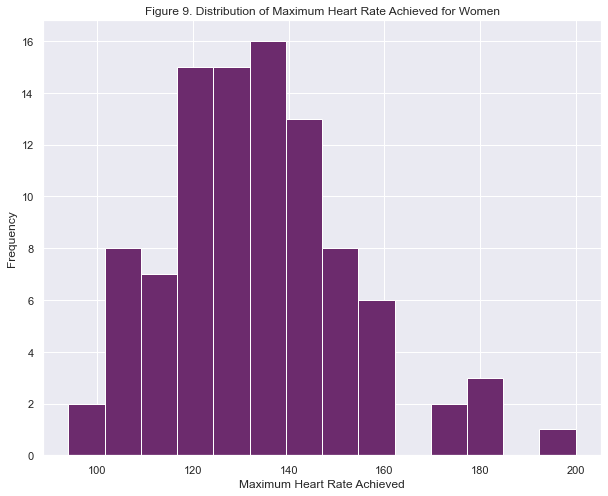

In [28]:
sns.set_palette("flare_r")
df[(df['thalach'] > 0) & (df['sex'] == 0.0)].trestbps.plot(kind='hist', bins=14)
plt.title('Figure 9. Distribution of Maximum Heart Rate Achieved for Women')
plt.xlabel('Maximum Heart Rate Achieved');

# Statistics and Transformations

In [9]:
stat = ols(formula='trestbps ~ age', data=df).fit()

In [135]:
stat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               trestbps   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     27.18
Date:                Sat, 19 Sep 2020   Prob (F-statistic):           3.48e-07
Time:                        17:51:06   Log-Likelihood:                -1262.3
No. Observations:                 297   AIC:                             2529.
Df Residuals:                     295   BIC:                             2536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    100.5966      6.046     16.640      0.000      88.699     112.494
age            0.5701      0.109      5.214      0.000       0.355       0.785
==============================================================================
Omnibus:                       21.250   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.106
Skew:                           0.569   Prob(JB):                     2.14e-06
Kurtosis:                       3.902   Cond. No.                         338.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

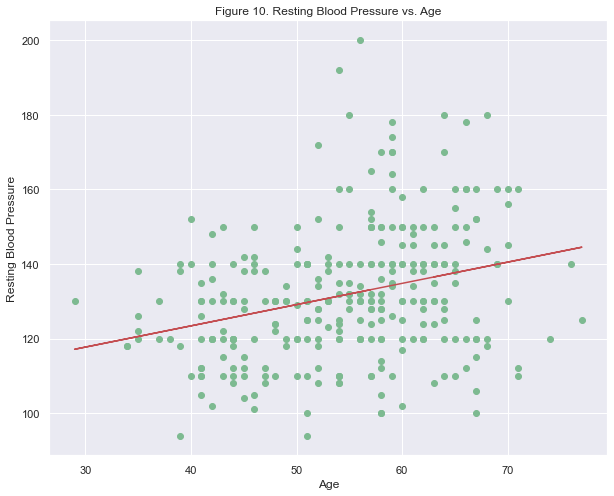

In [10]:
tmp = stat.params[1]*df['age'] + stat.params[0]

sns.set_palette("crest")
plt.scatter(df['age'], df['trestbps'])
plt.plot(df['age'], tmp, c='r')
plt.xlabel('Age')
plt.ylabel('Resting Blood Pressure')
plt.title('Figure 10. Resting Blood Pressure vs. Age');

Above a linear regression has been attempted on predicting one's resting blood pressure based on their age. However it is shown below that one of the assumptions for this model has been violated, 'Constant variance'. From Wikipedia's article on Linear Regression, https://en.wikipedia.org/wiki/Linear_regression, one of the assumptions is the residuals will be normal distributed. We see in the histogram, Figure 11, that there is a negative skew to this distribution and is not normally distributed, and the Kurtosis is approximately one when it should be closer to three. 

Also the R<sup>2</sup> value for this linear regression is only 0.084 which is a poor fit indead. One of the reasons machine learning has become so important is to come up with more sophiscated models to predict ones medical condition. If we are having a hard time predicting a person's blood pressure, than predicting if they have heart disease will be orders of magnitude more difficult!

count    2.970000e+02
mean     4.406800e-14
std      1.699691e+01
min     -6.747517e+01
25%     -1.032591e+01
50%      8.143871e-01
75%      1.194570e+01
max      3.879644e+01
dtype: float64

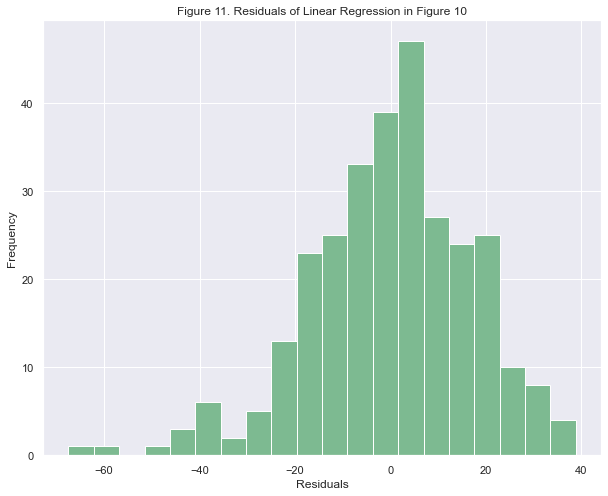

In [11]:
tmp_df = tmp - df['trestbps']
tmp_df.hist(bins=20)
plt.title('Figure 11. Residuals of Linear Regression in Figure 10')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
tmp_df.describe()

In [15]:
tmp_df.skew()

-0.5722868823804681

In [16]:
tmp_df.kurtosis()

0.937352812271532

Scatter Plot below takes a while to run and can be skipped.

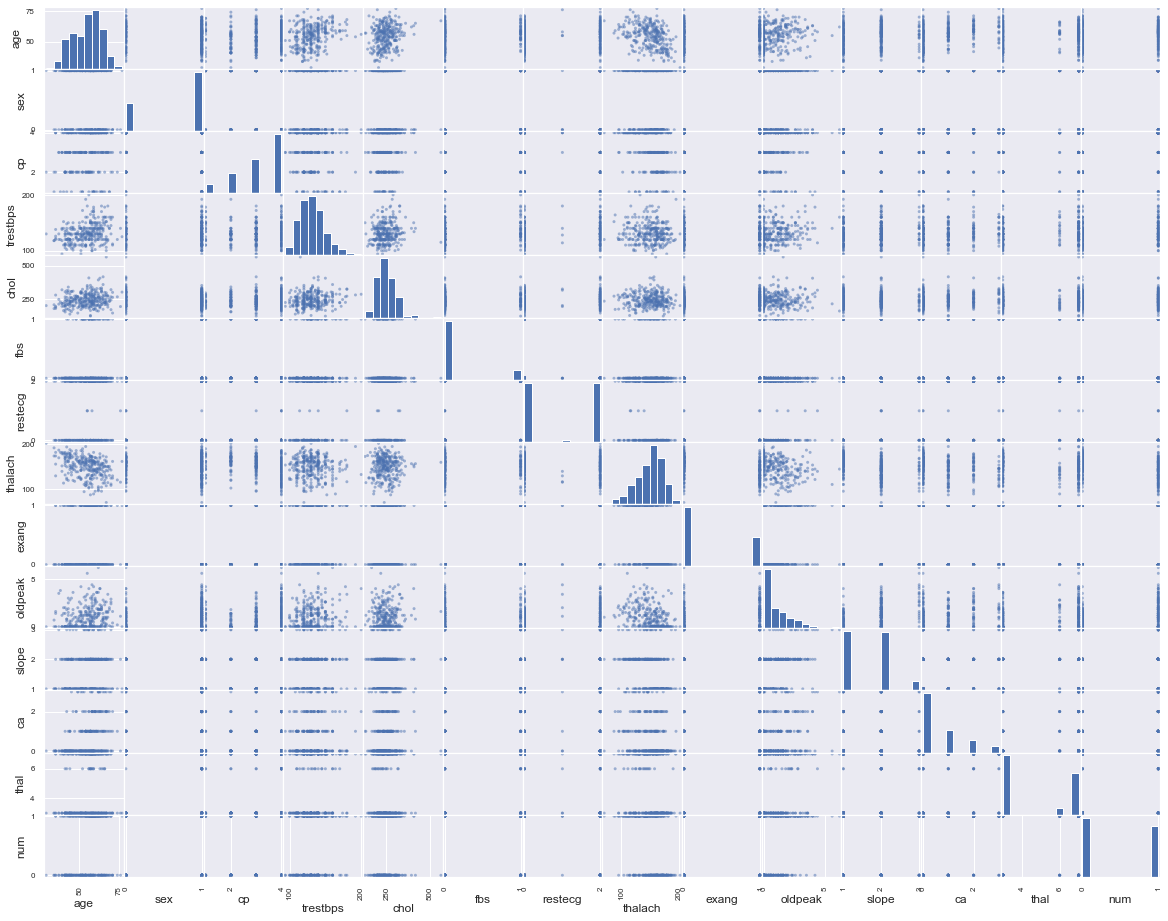

In [79]:
pd.plotting.scatter_matrix(df, figsize=(20,16));

## Addressing Skew and Scaling Input Variables

Many machine learning models benefit from having their input variables being having a normal distrubtion. We see along the diagonal of the scatter matrix plot above that some columns do not have a normal distribution, these are trestbps, thalch, chol, and oldpeak. We see their skew below

In [138]:
df['trestbps'].skew()
#df['trestbps'].kurtosis()

0.7000697177568133

In [132]:
df['thalach'].skew()

-0.5365400799355459

In [133]:
df['chol'].skew()

1.1180955225671279

In [134]:
df['oldpeak'].skew()

1.2471313241482946

We can use scipy stats module which will compute boxcox transformations (power transformation) on our skewed data (thalach, trestbps, and chol) and a yeojohnson transformation on our 'oldpeak' data. I would have used boxcox for all the data but 'oldpeak' has values that equal zero and boxcox can not handle values equal or less than zero.

In [37]:
sci_tmp = stats.boxcox_normmax(df['trestbps'].values)

/Users/DavidH/anaconda2/envs/py382/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [38]:
sci_tt = stats.boxcox(df['trestbps'].values, sci_tmp)

In [39]:
stats.skew(sci_tt)

0.0037114292536530053

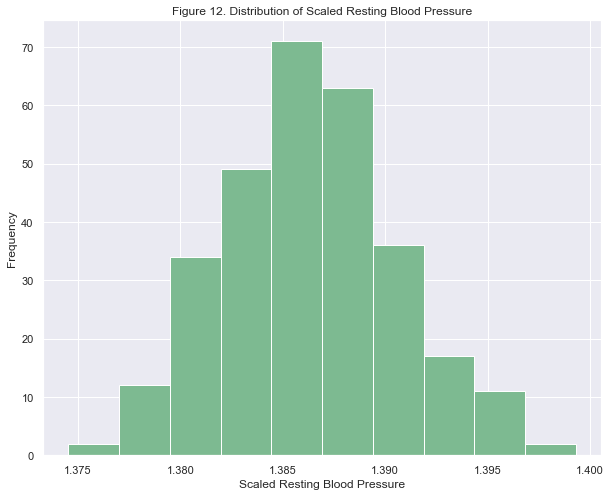

In [40]:
plt.hist(sci_tt);
plt.title('Figure 12. Distribution of Scaled Resting Blood Pressure')
plt.xlabel('Scaled Resting Blood Pressure')
plt.ylabel('Frequency');

Compared to original distribution shown below the transformation above is now closer to a Gaussian distribution.

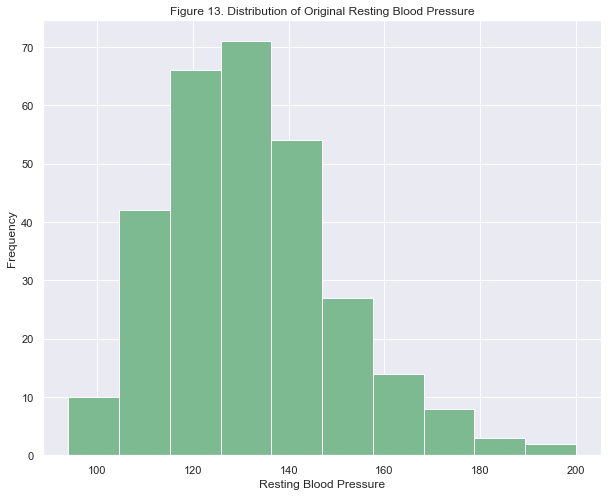

In [41]:
df['trestbps'].hist()
plt.title('Figure 13. Distribution of Original Resting Blood Pressure')
plt.xlabel('Resting Blood Pressure')
plt.ylabel('Frequency');

In [158]:
df['oldpeak'].describe()

count    297.000000
mean       1.055556
std        1.166123
min        0.000000
25%        0.000000
50%        0.800000
75%        1.600000
max        6.200000
Name: oldpeak, dtype: float64

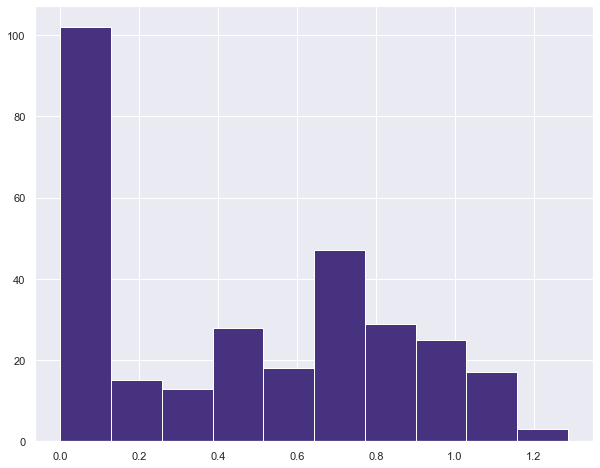

In [21]:
sns.set_palette("viridis")
box_peak = stats.yeojohnson_normmax(df['oldpeak'].values)
box_peak = stats.yeojohnson(df['oldpeak'].values, box_peak)
df_T['oldpeak'] = box_peak
plt.hist(box_peak);

In [20]:
stats.skew(box_peak)

0.11474944210994208

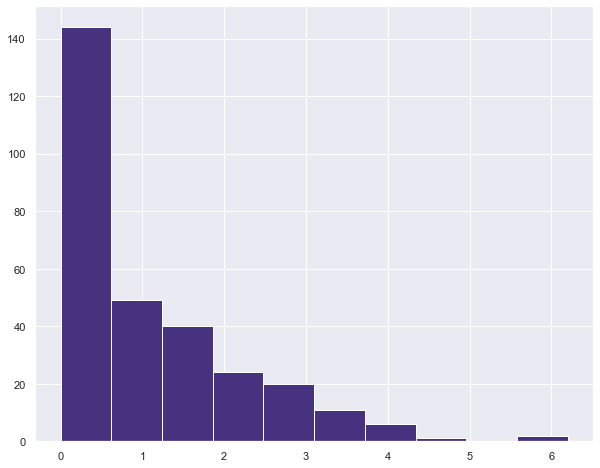

In [22]:
df['oldpeak'].hist()

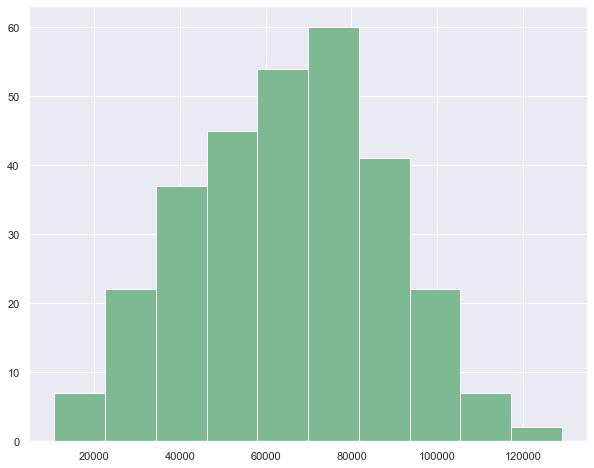

In [23]:
sns.set_palette("crest")
box_thal = stats.boxcox_normmax(df['thalach'].values)
box_thal = stats.boxcox(df['thalach'].values, box_thal)
df_T['thalach'] = box_thal
plt.hist(box_thal);

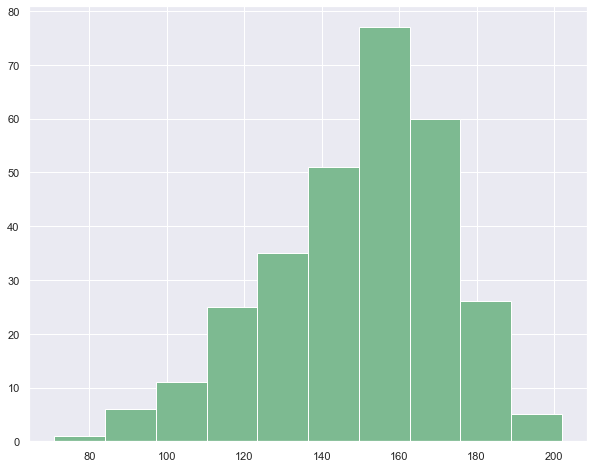

In [24]:
df['thalach'].hist();

In [167]:
stats.skew(box_thal)

-0.02153700558620656

/Users/DavidH/anaconda2/envs/py382/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


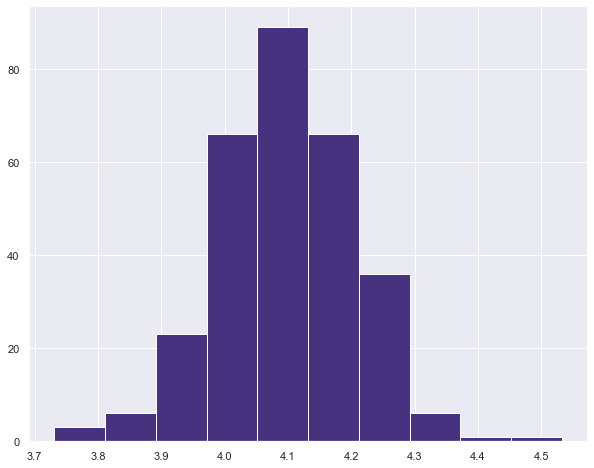

In [25]:
sns.set_palette("viridis")
box_chol = stats.boxcox_normmax(df['chol'].values)
box_chol = stats.boxcox(df['chol'].values, box_chol)
df_T['chol'] = box_chol
plt.hist(box_chol);

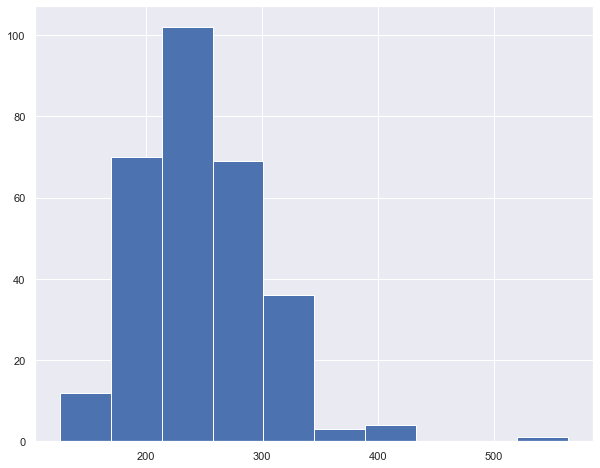

In [170]:
plt.hist(df['chol']);

In [26]:
stats.skew(box_chol)

-0.04094429306060899

Lastly we use RobustScaler function from sklean preprocessing module which is meant to good at dealing with outliers when scaling the data. It does this by removing the median and scales the data according to the quantile range

In [331]:
scaler = RobustScaler()
collist = df_T.columns.tolist()
collist.remove('num')
#df_T[['thalach','oldpeak','chol','trestbps']] = scaler.fit_transform(df_T[['thalach','oldpeak','chol','trestbps']])
df_T[collist] = scaler.fit_transform(df_T[collist])

## Dummy Variables

Also need dummy variables in our dataframe for all the categorical variables in the dataset. This will help the machine learning models handle categorical data.

In [332]:
cat_var = ['cp','restecg','slope','thal','ca']
data = pd.get_dummies(df, prefix=cat_var, columns=cat_var)
data_T = pd.get_dummies(df_T, prefix=cat_var, columns=cat_var)

# Models without Transformations

In [115]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('num',axis=1), data['num'], test_size=0.2, random_state=42)

## K Neighbors Classifier

In [116]:
neigh = KNeighborsClassifier()
parameters = {
    'n_neighbors':[2,3,4,5,6,7,8,9],
    'weights':('uniform','distance'),
    'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
    'leaf_size':[15,20,25,30,35,40,45],
    'p':[1,2,3],
}
clf = GridSearchCV(neigh, parameters, cv=5, n_jobs=-1, verbose=5)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 3568 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 6720 out of 6720 | elapsed:   12.4s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'leaf_size': [15, 20, 25, 30, 35, 40, 45],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
                         'p': [1, 2, 3], 'weights': ('uniform', 'distance')},
             verbose=5)

In [191]:
clf.best_params_

{'algorithm': 'auto',
 'leaf_size': 15,
 'n_neighbors': 9,
 'p': 1,
 'weights': 'uniform'}

In [118]:
clf.best_score_

0.6918439716312056

In [119]:
clf.best_estimator_.score(X_test, y_test)

0.65

## Logistic Regression Classifier

In [350]:
lr = LogisticRegression()
estimators = {
    'penalty':('l1', 'l2', 'elasticnet'),
    'tol':[1e-6,1e-5,1e-4,1e-3,1e-2],
    'C':[0.01,0.05,0.1,0.5,1.0,2.0],
    'solver':('newton-cg','lbfgs','liblinear','sag','saga'),
    'max_iter':[10000]
}

clf_lr = GridSearchCV(lr, estimators, cv=5, n_jobs=-1, verbose=5)
clf_lr.fit(X_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 2081 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:   38.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'max_iter': [10000],
                         'penalty': ('l1', 'l2', 'elasticnet'),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'),
                         'tol': [1e-06, 1e-05, 0.0001, 0.001, 0.01]},
             verbose=5)

In [351]:
clf_lr.best_params_

{'C': 1.0,
 'max_iter': 10000,
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 0.01}

In [352]:
clf_lr.best_score_

0.8311170212765957

In [353]:
clf_lr.best_estimator_.score(X_test, y_test)

0.8833333333333333

## SVC Classifier

In [366]:
svc = SVC()
est_svc = {
    'kernel':('linear', 'sigmoid'),
    'degree':[3,4,5,6],
    'C':[0.01,0.05,0.1,0.5,1.0,2.0],
    'tol':[1e-4,1e-3,1e-2],
    'gamma':('scale','auto')
}

clf_svc = GridSearchCV(svc, est_svc, cv=5, n_jobs=-1, verbose=5)
clf_svc.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1094 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1343 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   28.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   30.5s finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'degree': [3, 4, 5, 6], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'sigmoid'),
                         'tol': [0.0001, 0.001, 0.01]},
             verbose=5)

In [367]:
clf_svc.best_params_

{'C': 2.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001}

In [368]:
clf_svc.best_score_

0.8355496453900709

In [369]:
clf_svc.best_estimator_.score(X_test,y_test)

0.85

## Random Forest Classifier

In [374]:
rf = RandomForestClassifier()
est_rf = {
    'criterion':('gini', 'entropy'),
    'n_estimators':[50,80,100,120,150,180,200],
    'max_depth':[None,1,2,3,4,5],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2]
}

clf_rf = GridSearchCV(rf, est_rf, cv=5, n_jobs=-1, verbose=5)
clf_rf.fit(X_train, y_train)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  2.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 80, 100, 120, 150, 180, 200]},
             verbose=5)

In [375]:
clf_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

In [376]:
clf_rf.best_score_

0.835372340425532

In [377]:
clf_rf.best_estimator_.score(X_test,y_test)

0.8833333333333333

# Model with Transformations

In [333]:
X_tr, X_t, y_tr, y_t = train_test_split(data_T.drop('num',axis=1), data_T['num'], test_size=0.2, random_state=42)

## K Neighbors Classifier

In [334]:
neigh_T = KNeighborsClassifier()
parameters_T = {
    'n_neighbors':[2,3,4,5,6,7,8,9],
    'weights':('uniform','distance'),
    'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
    'leaf_size':[15,20,25,30,35,40,45],
    'p':[1,2,3],
}
clf_T = GridSearchCV(neigh_T, parameters_T, cv=5, n_jobs=-1, verbose=5)
clf_T.fit(X_tr, y_tr)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 6720 out of 6720 | elapsed:   13.2s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'leaf_size': [15, 20, 25, 30, 35, 40, 45],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9],
                         'p': [1, 2, 3], 'weights': ('uniform', 'distance')},
             verbose=5)

In [335]:
clf_T.best_params_

{'algorithm': 'auto',
 'leaf_size': 15,
 'n_neighbors': 7,
 'p': 1,
 'weights': 'distance'}

In [336]:
clf_T.best_score_

0.8312943262411349

In [337]:
clf_T.best_estimator_.score(X_t, y_t)

0.9

## Logisitic Regression Classifier

In [358]:
lr_T = LogisticRegression()
estimators_T = {
    'penalty':('l1', 'l2', 'elasticnet'),
    'tol':[1e-6,1e-5,1e-4,1e-3,1e-2],
    'C':[0.01,0.05,0.1,0.5,1.0,2.0],
    'solver':('newton-cg','lbfgs','liblinear','sag','saga'),
    'max_iter':[10000]
}

clf_lr_T = GridSearchCV(lr_T, estimators_T, cv=5, n_jobs=-1, verbose=5)
clf_lr_T.fit(X_tr, y_tr)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1914 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:    2.6s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'max_iter': [10000],
                         'penalty': ('l1', 'l2', 'elasticnet'),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'),
                         'tol': [1e-06, 1e-05, 0.0001, 0.001, 0.01]},
             verbose=5)

In [359]:
clf_lr_T.best_params_

{'C': 0.01,
 'max_iter': 10000,
 'penalty': 'l2',
 'solver': 'newton-cg',
 'tol': 1e-06}

In [360]:
clf_lr_T.best_score_

0.8310283687943263

In [361]:
clf_lr_T.best_estimator_.score(X_t, y_t)

0.9

## SVC Classifier

In [366]:
svc = SVC()
est_svc = {
    'kernel':('linear', 'sigmoid'),
    'degree':[3,4,5,6],
    'C':[0.01,0.05,0.1,0.5,1.0,2.0],
    'tol':[1e-4,1e-3,1e-2],
    'gamma':('scale','auto')
}

clf_svc = GridSearchCV(svc, est_svc, cv=5, n_jobs=-1, verbose=5)
clf_svc.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1094 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1343 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 1425 out of 1440 | elapsed:   28.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   30.5s finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0],
                         'degree': [3, 4, 5, 6], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'sigmoid'),
                         'tol': [0.0001, 0.001, 0.01]},
             verbose=5)

In [367]:
clf_svc.best_params_

{'C': 2.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.0001}

In [368]:
clf_svc.best_score_

0.8355496453900709

In [369]:
clf_svc.best_estimator_.score(X_test,y_test)

0.85

## Random Forest Classifier

In [379]:
rf_T = RandomForestClassifier()
est_rf_T = {
    'criterion':('gini', 'entropy'),
    'n_estimators':[50,80,100,120,150,180,200],
    'max_depth':[None,1,2,3,4,5],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2]
}

clf_rf_T = GridSearchCV(rf_T, est_rf_T, cv=5, n_jobs=-1, verbose=5)
clf_rf_T.fit(X_tr, y_tr)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1176 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1986 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2328 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  2.1min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 80, 100, 120, 150, 180, 200]},
             verbose=5)

In [380]:
clf_rf_T.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [381]:
clf_rf_T.best_score_

0.8312943262411346

In [382]:
clf_rf_T.best_estimator_.score(X_t,y_t)

0.8833333333333333

# Conclusion

The datasets on heart disease has been used by many research groups around the world, in particular the Cleveland dataset. This project has investigated this datasetand have found some very interesting trends.
The data suggests old age is a significant factor to heart disease. Heart disease typically affects men more than women and this trend was also observed in men at a younger age than women, on average. Individuals with heart disease have a lower maximum heart rate, whereas healthy patients are able to achieve a higher maximum heart rate. It is also important to note that high cholesterol is dangerous and one will have a higher likelihood of heart disease.

Some limitations encountered in this dataset is how small it is. There are only 303 rows of data and we only used 297 after the cleaning stage of this analysis. In the future one could acquire more data since this is typically is a better approach than even the most sophisticated models in machine learning, as stated by Peter Norvig et al. (2009), “But invariably simple models and a lot data trump more elaborate models based on less data.”(2009)<sup>6</sup>.


6. https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/35179.pdf